In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [27]:
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self, p):
        super(MaskedCrossEntropyLoss, self).__init__()
        self.p = max(0, min(1, p))
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, target):
        mask = torch.bernoulli(torch.full((logits.size(1),), 1 - self.p, device=logits.device, dtype=torch.float))
        masked_logits = logits * mask  # Зануление компонент
        loss = self.ce_loss(masked_logits, target)
        return loss.mean() / (1 - self.p) if self.p < 1 else loss.mean()


In [28]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim=32*32*3, num_classes=100):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(self.flatten(x))


In [29]:
def compute_true_gradient(model, dataloader, device, criterion):
    model.zero_grad()
    true_grads = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
    total_samples = 0

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        batch_size = data.size(0)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Аккумулируем градиенты
        for name, param in model.named_parameters():
            if param.grad is not None:
                true_grads[name] += param.grad * batch_size
        total_samples += batch_size
        model.zero_grad()

    # Нормализуем градиенты по числу объектов
    for name in true_grads:
        true_grads[name] /= total_samples

    return true_grads

In [30]:
# Функция для вычисления батчевых градиентов и дисперсии
def compute_batch_gradients_and_variance(model, dataloader, true_grads, device, criterion, n):
    batch_grads = []
    model.zero_grad()

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Собираем градиенты для батча
        batch_grad = {name: param.grad.clone() for name, param in model.named_parameters() if param.grad is not None}
        batch_grads.append(batch_grad)
        model.zero_grad()

    # Вычисляем дисперсию градиентов
    variances = {}
    for name in true_grads:
        grad_diffs = []
        for batch_grad in batch_grads:
            diff = batch_grad[name] - true_grads[name]
            grad_diffs.append(diff.view(-1))
        grad_diffs = torch.stack(grad_diffs)
        variances[name] = torch.var(grad_diffs, dim=0).mean().item()

    return variances

In [32]:
def run_experiment(n, p, b, num_epochs=1, num_runs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.ToTensor()
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=n, shuffle=True)

    run_variances = []
    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs} for n={n}, p={p}")
        model = LogisticRegression().to(device)
        criterion_true = MaskedCrossEntropyLoss(p=0).to(device)
        criterion_batch = MaskedCrossEntropyLoss(p=p).to(device)

        for epoch in range(num_epochs):
            true_grads = compute_true_gradient(model, trainloader, device, criterion_true)
            variances = compute_batch_gradients_and_variance(model, trainloader, true_grads, device, criterion_batch, n)
            avg_variance = np.mean(list(variances.values()))
            run_variances.append(avg_variance)

    # Усреднение дисперсии по запускам
    avg_variance = np.mean(run_variances)
    print(f"n={n}, p={p}, avg_variance={avg_variance}")
    return {"n": n, "p": p, "variance": avg_variance}

Skipping n=32, p=-1.0 (invalid p)
Running experiment with n=64, p=0.0
Run 1/10 for n=64, p=0.0
Run 2/10 for n=64, p=0.0
Run 3/10 for n=64, p=0.0
Run 4/10 for n=64, p=0.0
Run 5/10 for n=64, p=0.0
Run 6/10 for n=64, p=0.0
Run 7/10 for n=64, p=0.0
Run 8/10 for n=64, p=0.0
Run 9/10 for n=64, p=0.0
Run 10/10 for n=64, p=0.0
n=64, p=0.0, avg_variance=0.00010120669849129626
Running experiment with n=72, p=0.11111111111111116
Run 1/10 for n=72, p=0.11111111111111116
Run 2/10 for n=72, p=0.11111111111111116
Run 3/10 for n=72, p=0.11111111111111116
Run 4/10 for n=72, p=0.11111111111111116
Run 5/10 for n=72, p=0.11111111111111116
Run 6/10 for n=72, p=0.11111111111111116
Run 7/10 for n=72, p=0.11111111111111116
Run 8/10 for n=72, p=0.11111111111111116
Run 9/10 for n=72, p=0.11111111111111116
Run 10/10 for n=72, p=0.11111111111111116
n=72, p=0.11111111111111116, avg_variance=0.00010137175104318885
Running experiment with n=80, p=0.19999999999999996
Run 1/10 for n=80, p=0.19999999999999996
Run 2/10 

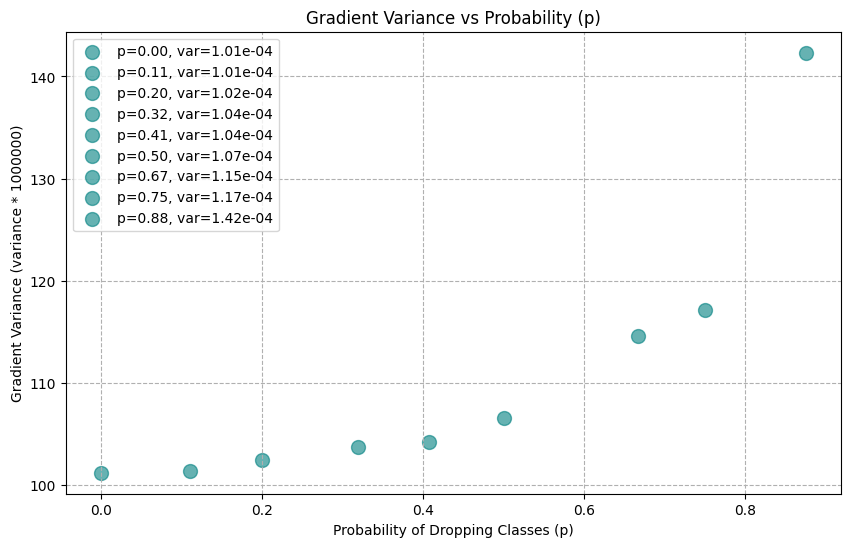

In [33]:
b = 6400
n_values = n_values = [32, 64, 72, 80, 94, 108, 128, 192, 256, 512]
results = []

for n in n_values:
    p = 1 - b / (n * 100)
    if p < 0 or p > 1:
        print(f"Skipping n={n}, p={p} (invalid p)")
        continue
    print(f"Running experiment with n={n}, p={p}")
    result = run_experiment(n, p, b, num_epochs=1, num_runs=10)
    results.append(result)

plt.figure(figsize=(10, 6))
for res in results:
    plt.scatter(res['p'], res['variance']*1000000, s=100, alpha=0.6, c='teal',
                label=f"p={res['p']:.2f}, var={res['variance']:.2e}")
plt.xscale('linear')
plt.xlabel('Probability of Dropping Classes (p)')
plt.ylabel('Gradient Variance (variance * 1000000)')
plt.title('Gradient Variance vs Probability (p)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()